# Categorizing movie reviews - ML for texts

<div style="border:solid black 1px; padding: 20px">
<ul>
<li>The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews.</li>
<br/>
<li><b>The goal is to train a model to automatically detect negative reviews.</b></li>
<br/>
<li>You'll be using a dataset of IMBD movie reviews with polarity labelling to <font color='red'><u>build a model for classifying positive and negative reviews.</u></font></li>
<br/>
<li><b>It will need to have an <font color='red'>F1 score of at least 0.85.</font></b></li>
</ul>
</div>

<font size=4px; color='red'><b><u>Initialization - Import relevant libraries</u></b></font>

In [1]:
import seaborn as sns
import spacy
import math 
import torch
import transformers
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import seaborn as sns
import spacy
import re
import math 
import torch
import transformers

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data & Explore

In [4]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

* We have a dataframee of 47331 entries, with 17 attributes 
* Null values exist in 2 ccolumns only (small proportion - 2 entries only)
* memory usage are not large in comparison to the entries proportion

In [6]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
1874,tt0088695,movie,Alien Warrior,Alien Warrior,1986,\N,100,0,"Action,Crime,Sci-Fi",4.3,200,Hargh... this film is so bad it's almost good....,1,neg,0,test,2379
42312,tt0429177,movie,The Thing About My Folks,The Thing About My Folks,2005,\N,96,0,"Comedy,Drama",6.5,2272,This film is one of those that has a resoundin...,10,pos,1,train,4350
21445,tt0795421,movie,Mamma Mia!,Mamma Mia!,2008,\N,108,0,"Comedy,Musical,Romance",6.4,208249,"Everyone knows the so-called plot, so let me c...",2,neg,0,test,6223
15883,tt0390079,movie,Hari Om,Hari Om,2004,\N,108,0,"Comedy,Romance",6.3,110,"I loved this film, which I have just seen at t...",10,pos,1,test,3663
33004,tt0162677,movie,Summer of Sam,Summer of Sam,1999,\N,142,0,"Crime,Drama,Romance",6.7,35369,The film is a collection of cliche's on just a...,1,neg,0,train,7510
31070,tt0141831,short,Skeleton Frolic,Skeleton Frolic,1937,\N,7,0,"Animation,Comedy,Horror",6.8,172,"In 1929, director Walt Disney and animator Ub ...",8,pos,1,test,177
32455,tt0044070,movie,Starlift,Starlift,1951,\N,103,0,Musical,6.0,406,This oddity in the new DORIS DAY COLLECTION do...,3,neg,0,train,2727
25047,tt0462570,movie,On Probation,Tiempo de valientes,2005,\N,112,0,"Action,Comedy,Crime",7.6,5668,Should this be an American movie I'd rate it 7...,9,pos,1,train,2900
20788,tt0494253,movie,Long-Term Relationship,Long-Term Relationship,2006,\N,97,0,"Comedy,Drama,Romance",6.2,868,"Or listening to, for that matter. Even the sou...",2,neg,0,train,10981
40706,tt0840359,video,The Planet,The Planet,2006,\N,71,0,"Horror,Sci-Fi",3.8,273,"OK, so maybe it's because I'm from the North E...",10,pos,1,test,1377


In [7]:
print(df_reviews.isna().sum())


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [8]:
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

* train test were splitted in ratio of 1:1 almost

In [9]:
df_reviews['sp'].value_counts()

neg    23715
pos    23616
Name: sp, dtype: int64

* We see that the negative reviews are almost equal to the positive ones, fifty fifty 

In [10]:
x = ['average_rating','votes','start_year','rating','pos','runtime_minutes','idx','is_adult']
df_reviews[x].describe()

,average_rating,votes,start_year,rating,pos,idx,is_adult
count,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000,47331.000000,47331.000000
mean,5.998278,2.556292e+04,1989.631235,5.484608,0.498954,6279.697999,0.001732
std,1.494289,8.367004e+04,19.600364,3.473109,0.500004,3605.702545,0.041587
min,1.400000,9.000000e+00,1894.000000,1.000000,0.000000,0.000000,0.000000
25%,5.100000,8.270000e+02,1982.000000,2.000000,0.000000,3162.000000,0.000000
50%,6.300000,3.197000e+03,1998.000000,4.000000,0.000000,6299.000000,0.000000
75%,7.100000,1.397400e+04,2004.000000,9.000000,1.000000,9412.000000,0.000000
max,9.700000,1.739448e+06,2010.000000,10.000000,1.000000,12499.000000,1.000000


* 75% of the movies are non adult 
* 75% of the ratings are below 9
* average rating mean for all the movies is 5.99
* 75% of the start year of the movies are before 2005 

## EDA

Let's check the number of movies and reviews over years.

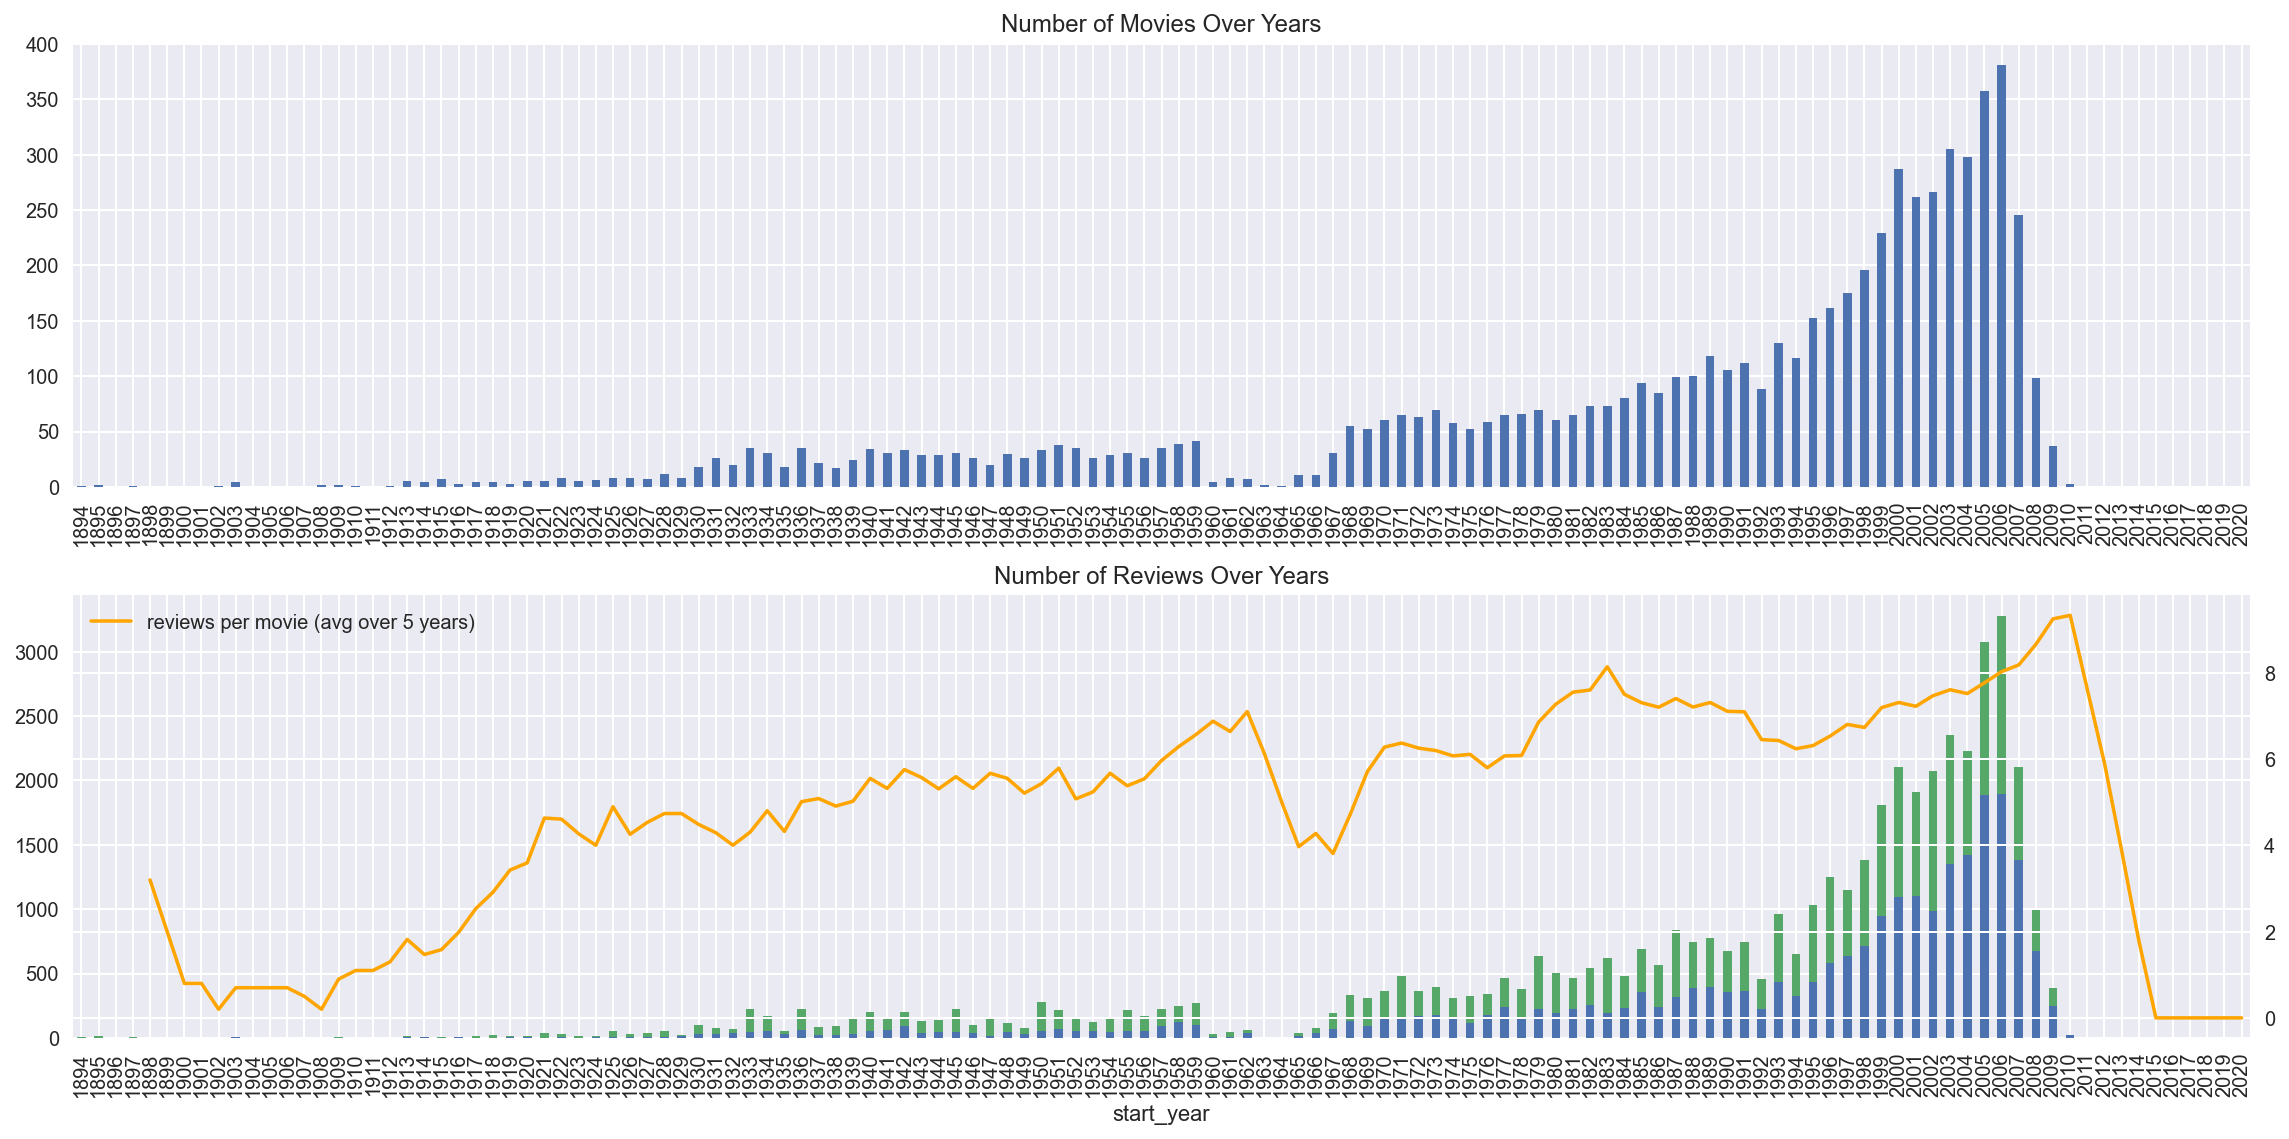

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

* Regardless of the number  of review vs the number of movies per year, the graphs look the same the distribution look similar on both of the graphs 
* On 2006 there is the max movies and number of reviews, acute decrease occur on 2007 and 2008

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

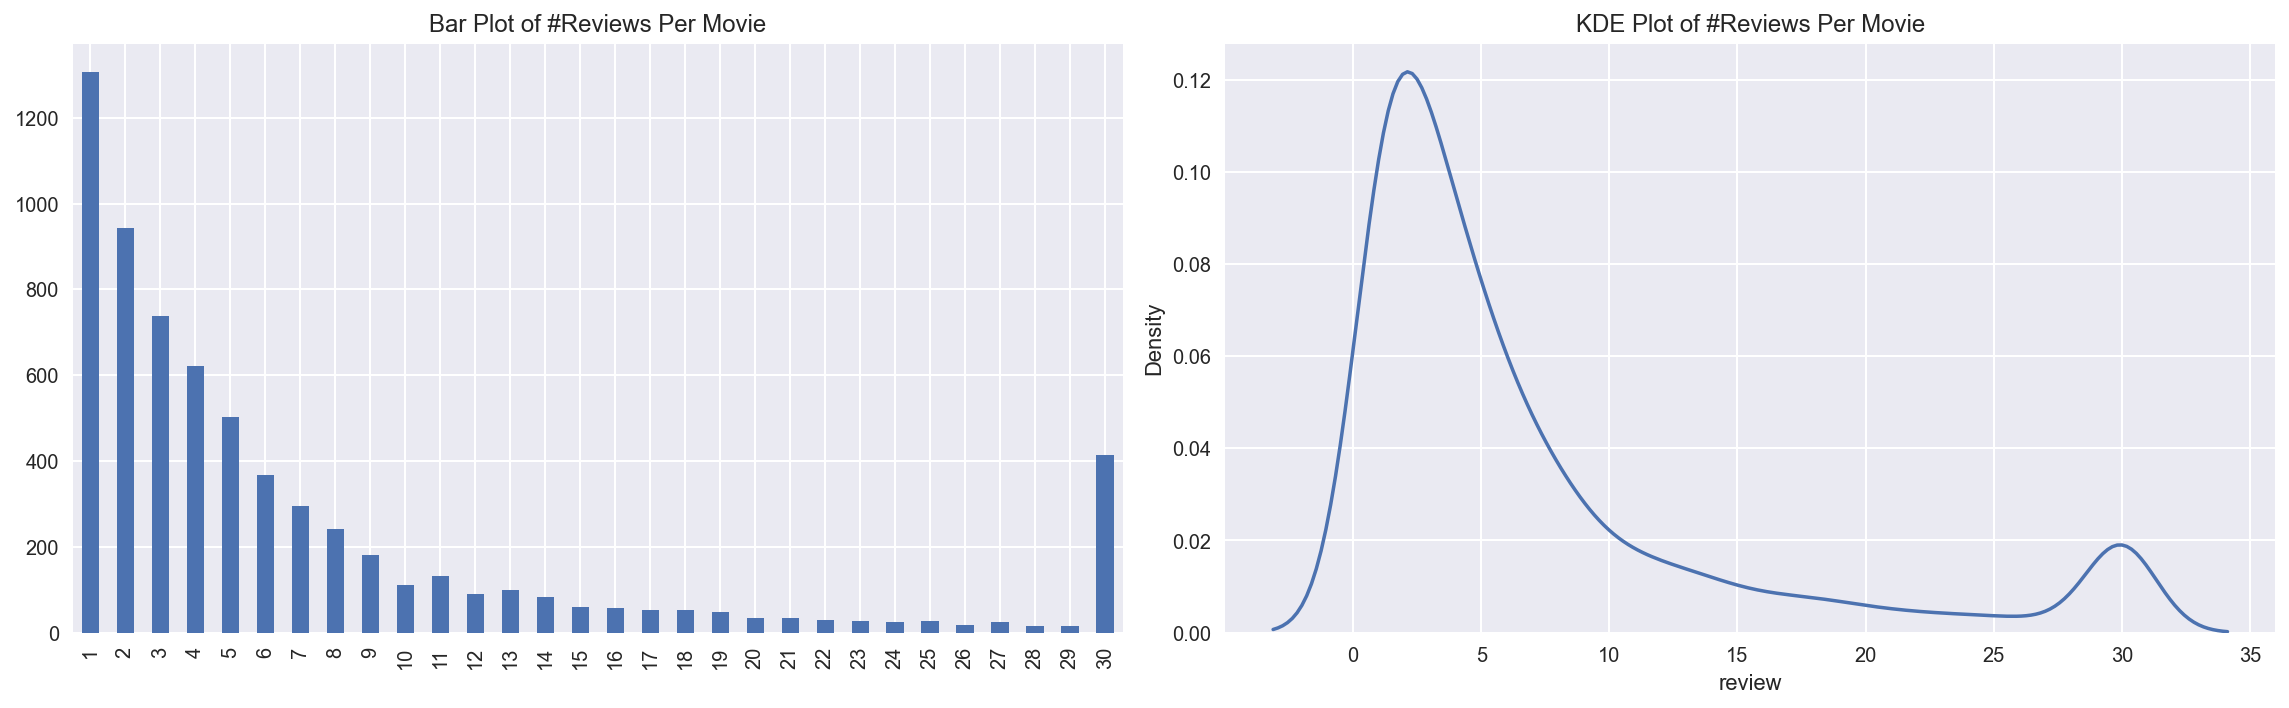

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

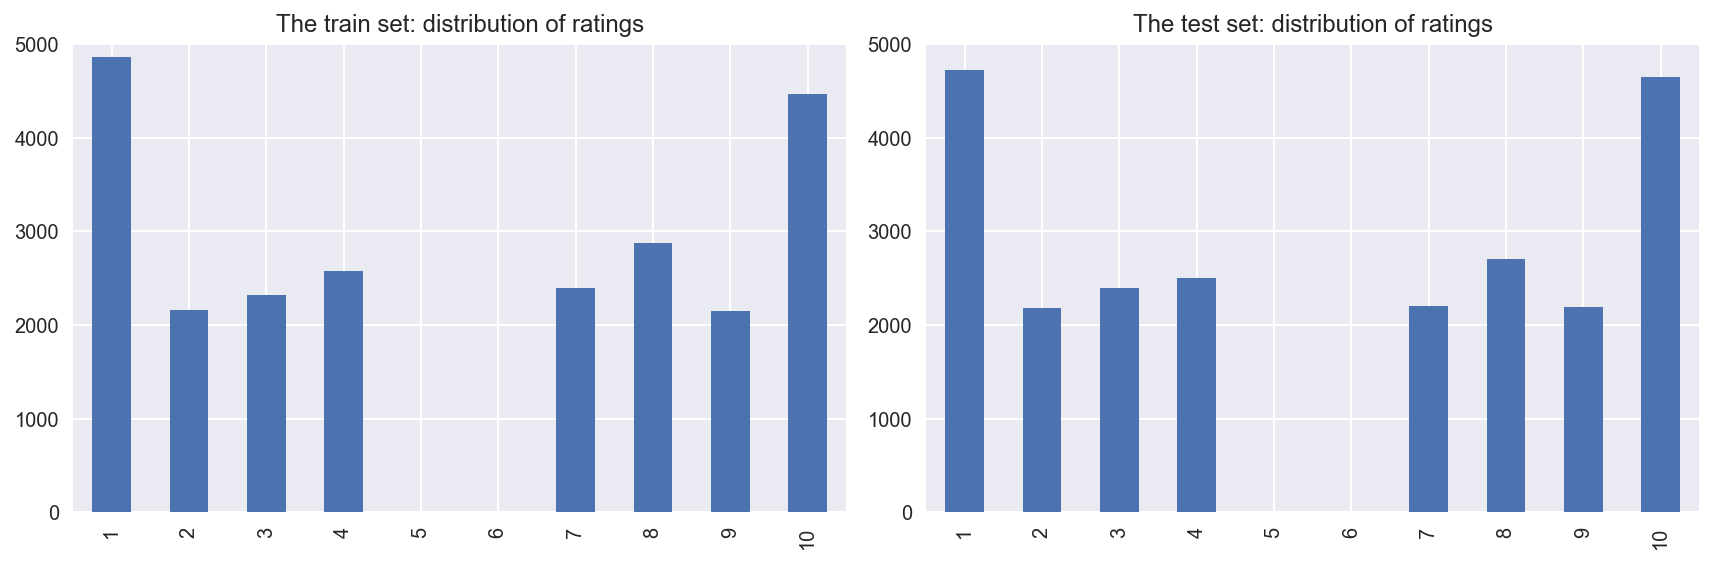

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

* Distribution of the ratings for both of the sets look very similar

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\Nida\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\Nida\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\Nida\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\Nida\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


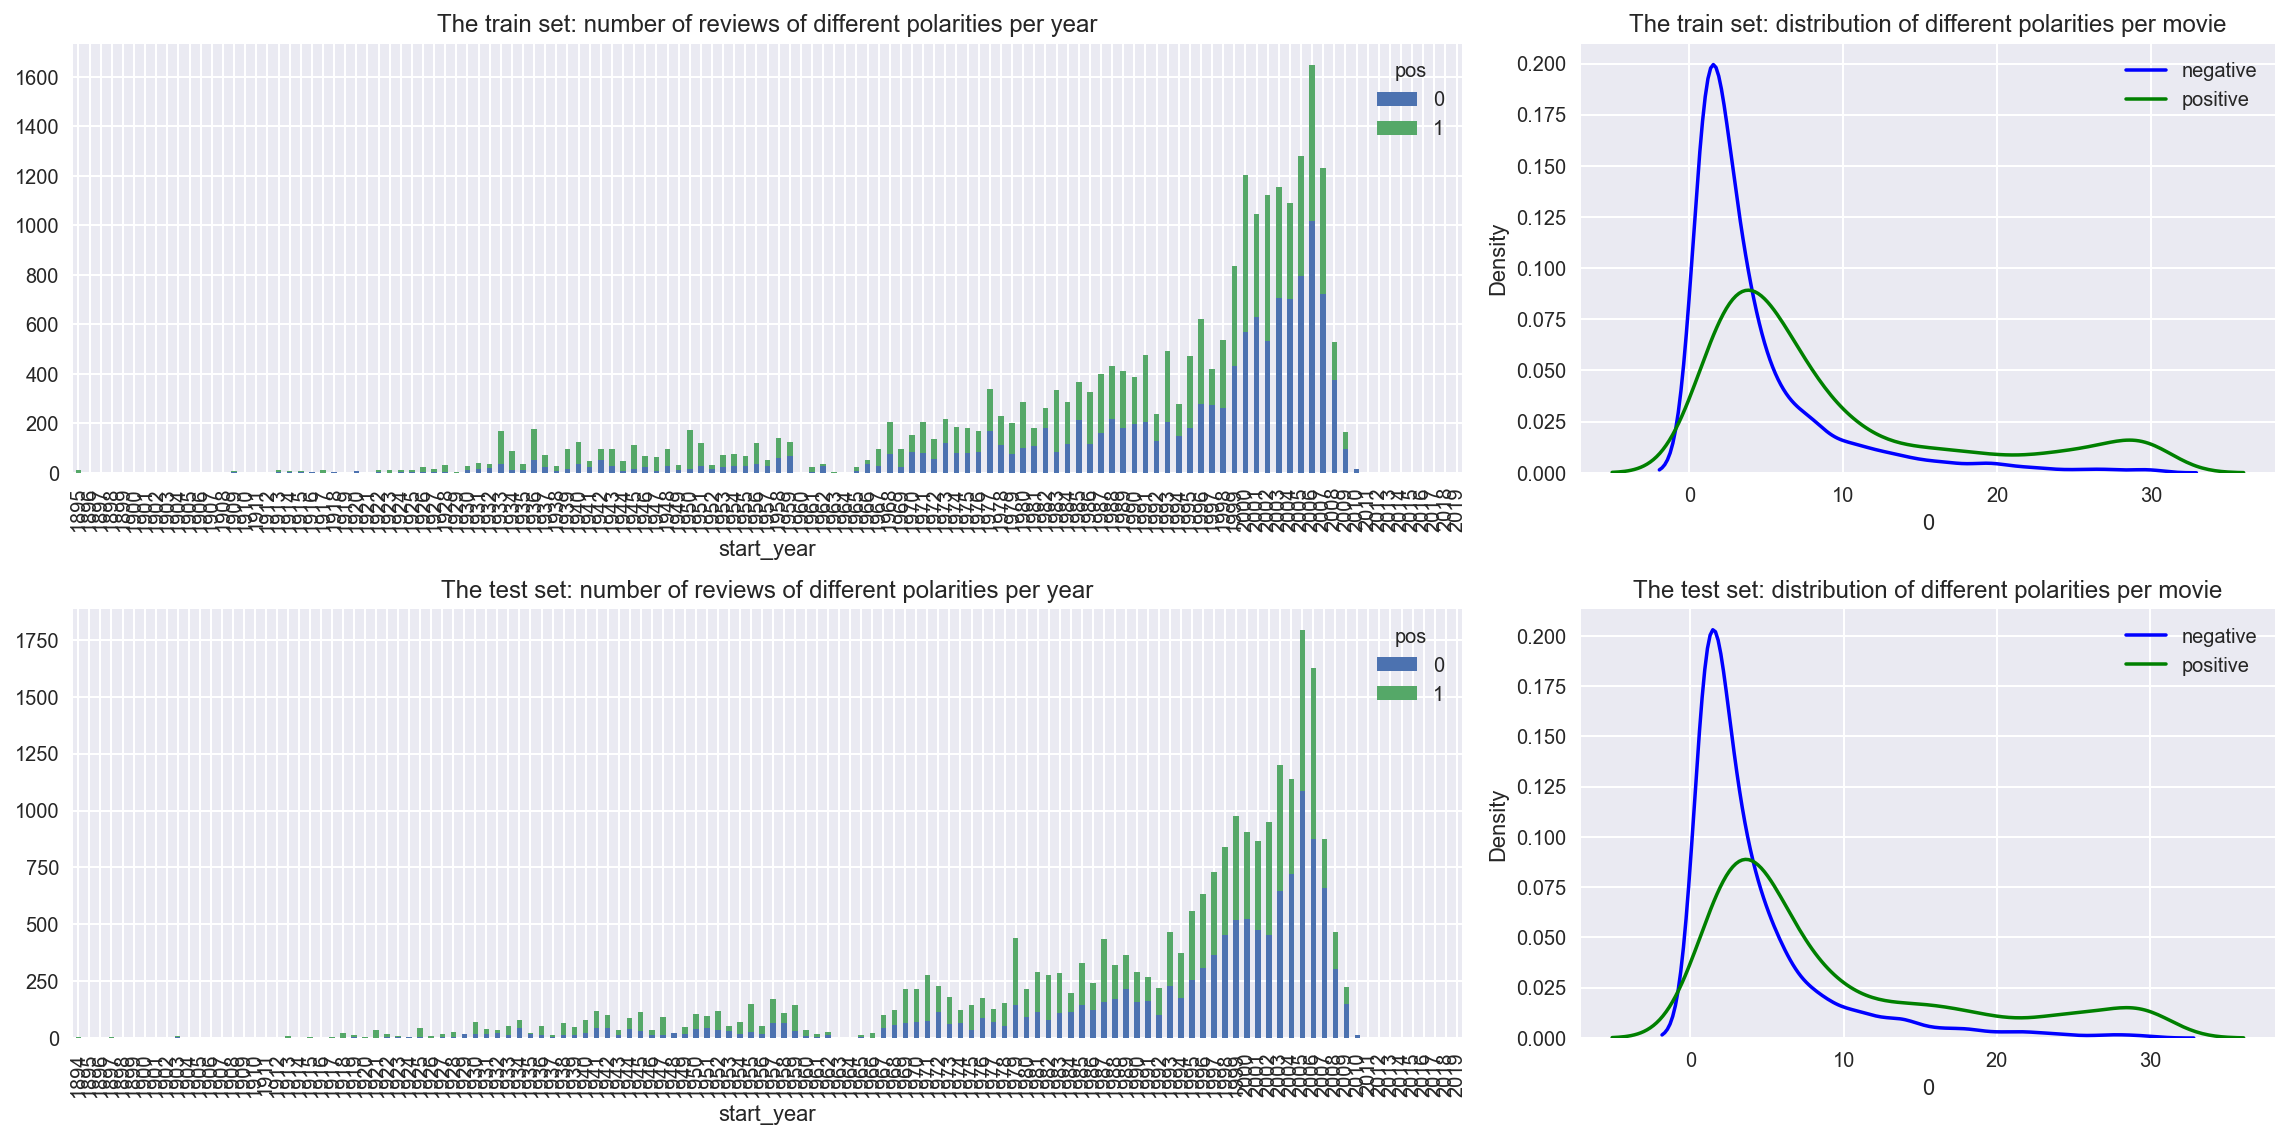

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

* Distribution of the reviews for both of the sets look very similar, test set got more reviews

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

In [17]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def clear_text_gen(text_review):
    text = text_review['review']
    pattern = r'[^a-zA-Z]'
    text = re.sub(pattern, " ", text)
    text = text.lower()
    text = text.split()
    text = " ".join(text)
    
    return text    

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
#applying the method to the new column review_norm
df_reviews['review_norm'] = df_reviews.apply(clear_text_gen,axis=1)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 1 - Constant

**Using the dummy classifier as the constant model**

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
train_features_1 = df_reviews_train['review_norm']
test_features_1 =df_reviews_test['review_norm']

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


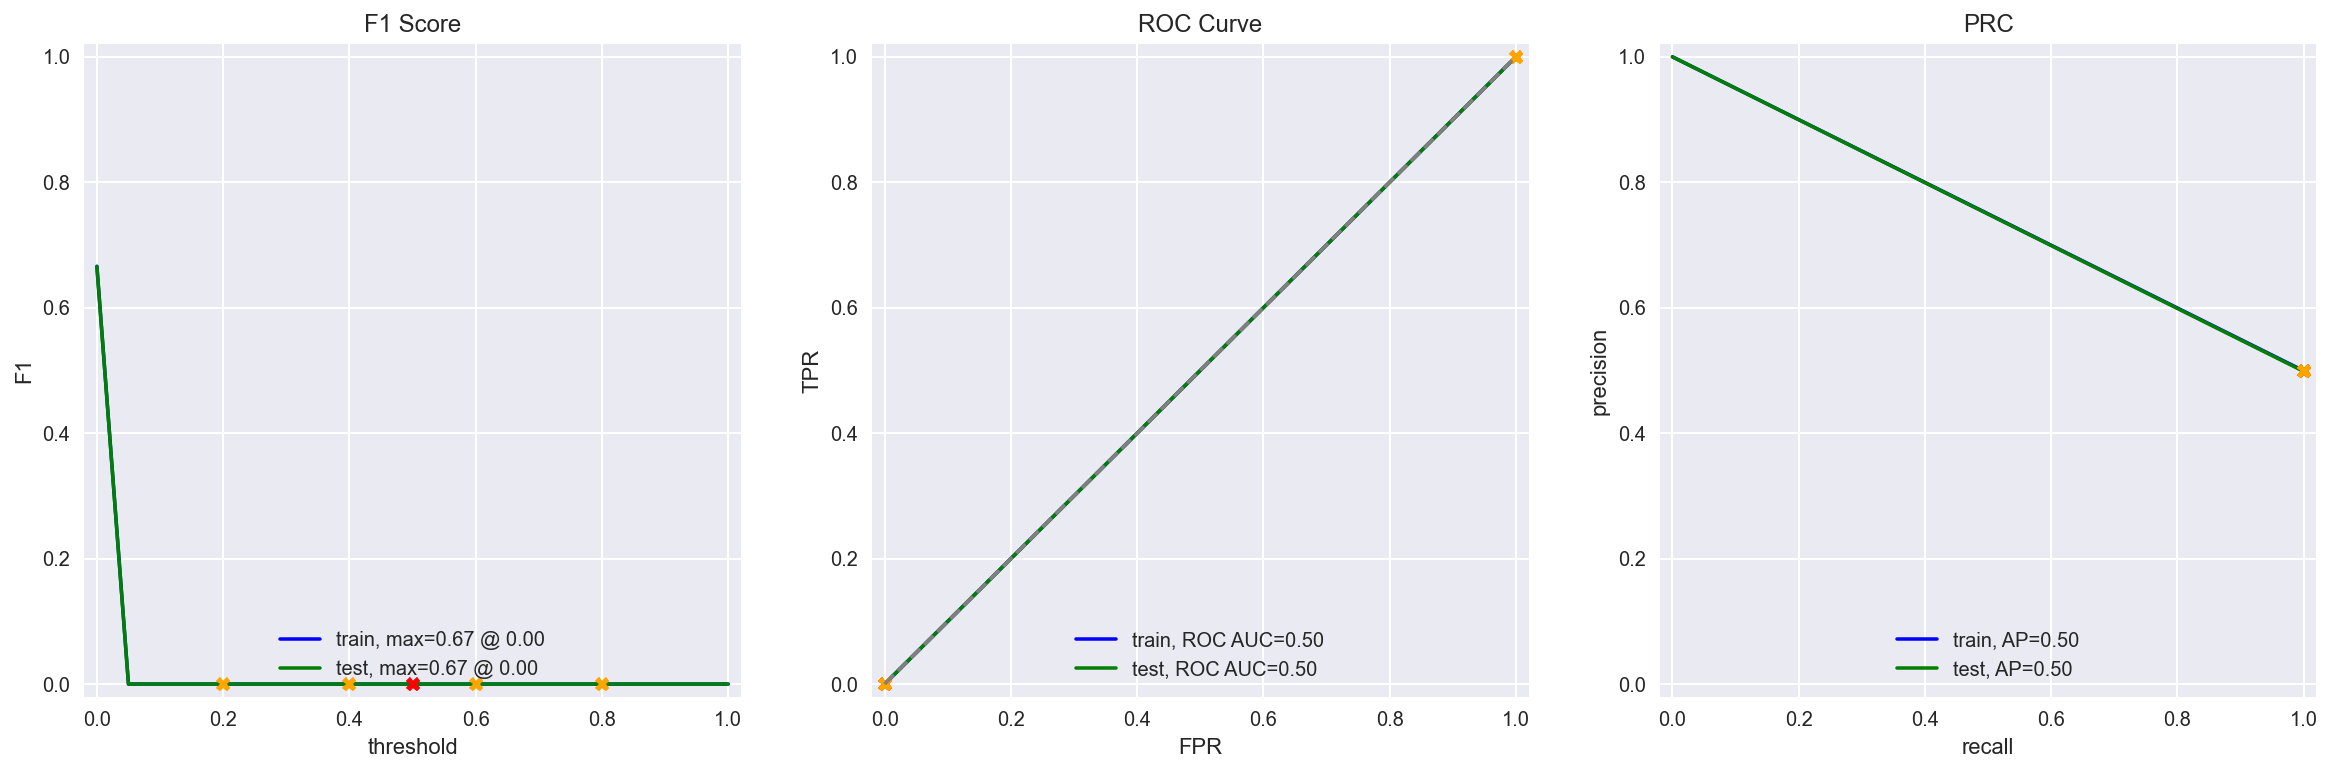

In [22]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_features_1,train_target)
evaluate_model(dummy_clf , train_features_1, train_target, test_features_1, test_target)

* For the dummy set the f1 score is zero for  both of the sets 
* All of the other metrics is equal to 0.5,
  * on the previous steps we see that the review of negativee and positive ones are equal
  * it is a dummy model and added the feature of most frequent
  * results above make sense 

### Model 2 - NLTK, TF-IDF and LR

TF-IDF

In [23]:
stop_words = set(nltk_stopwords.words('english'))
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())
    return clean_text

def lemm_text(text):
    text = clear_text(text)
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc]    
    return ' '.join(tokens)

In [24]:
%%time
df_reviews['review_lemm'] = df_reviews['review'].apply(lemm_text)

CPU times: total: 24min 59s
Wall time: 29min 49s


In [25]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

In [26]:
%%time
corpus_train = df_reviews_train['review_lemm']
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = tfidf_vectorizer_2.fit_transform(corpus_train)
corpus_test = df_reviews_test['review_lemm']
tf_idf_test = tfidf_vectorizer_2.transform(corpus_test)

CPU times: total: 13.4 s
Wall time: 13.6 s


In [27]:
train_features_2 = tf_idf_train
test_features_2 = tf_idf_test
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: total: 2.05 s
Wall time: 2.07 s


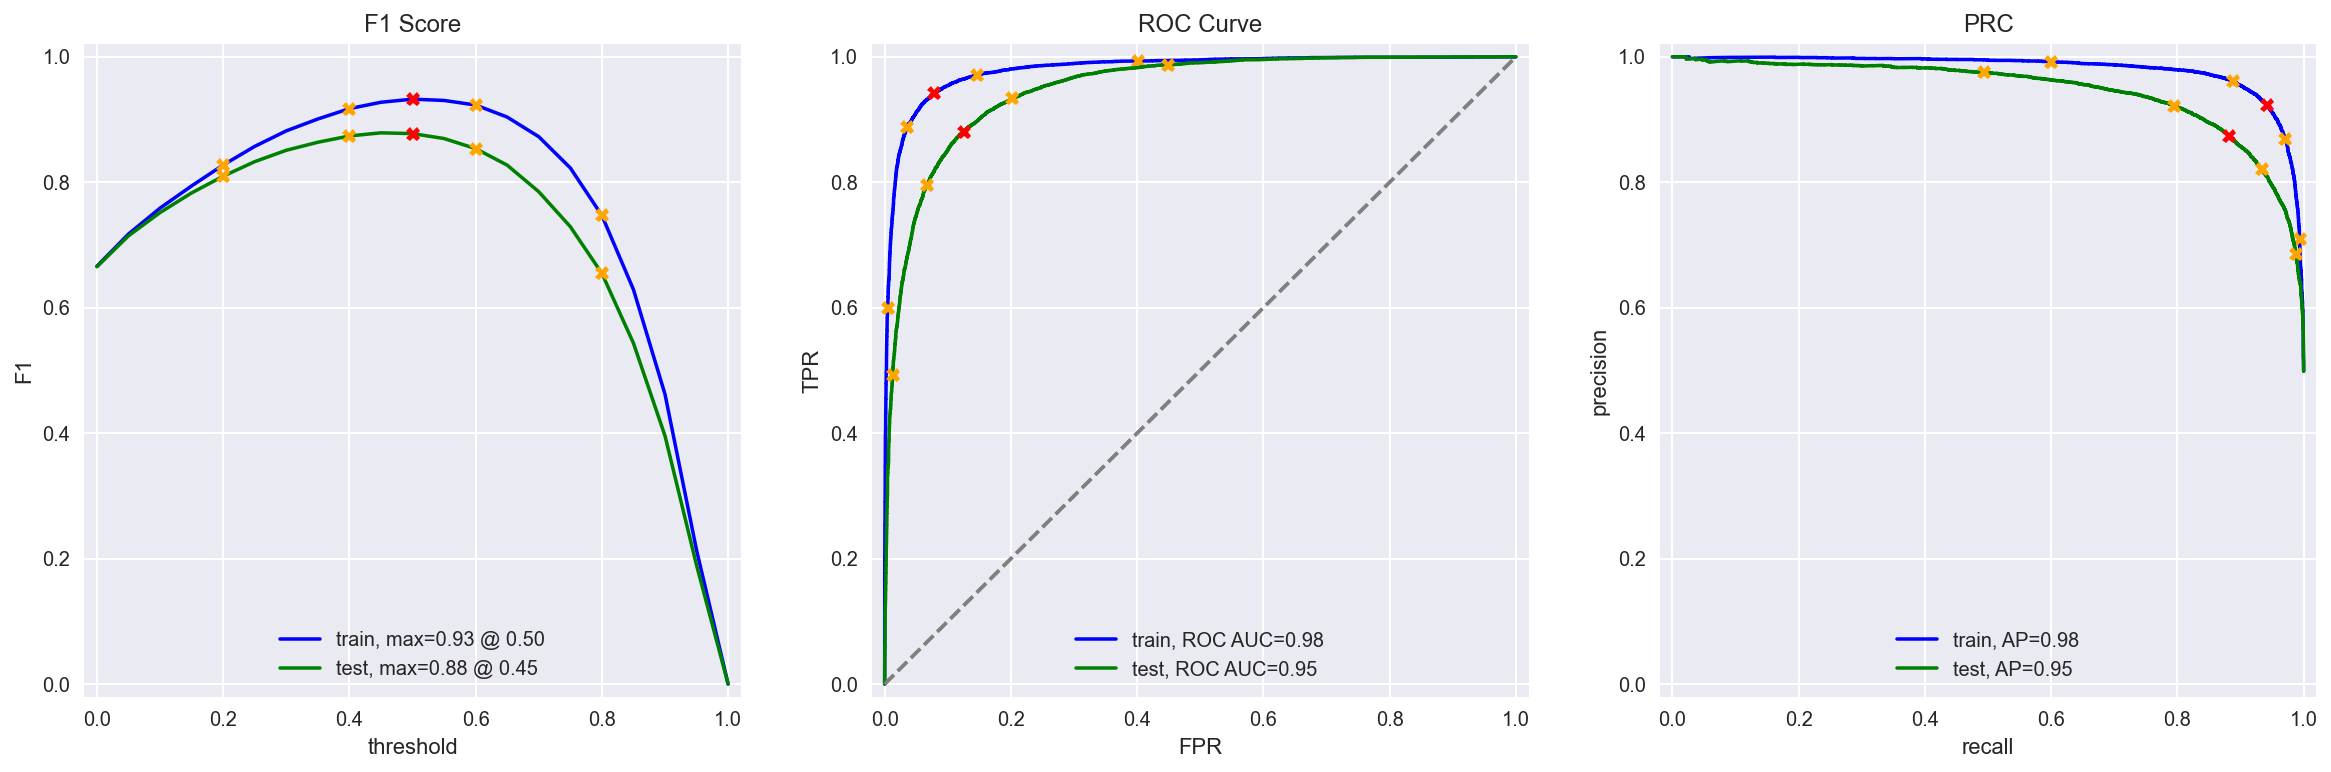

In [28]:
%%time
model_2 = LogisticRegression(random_state=12345,solver='liblinear')
model_2.fit(train_features_2,train_target)
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

* Applying lemmatization took long time and that is due to large number of reviews
* F1 score is great it is larger than 0.85 for both of the sets 
* Accuracy and F1 score are equal the same for ROC AUC and APS 

### Model 3 - spaCy, TF-IDF and LR

In [29]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())
    return clean_text

def text_preprocessing_3(text):
    text = clear_text(text)
    doc = nlp(text.lower())
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [31]:
%%time
df_reviews['review_lemm_nlp'] = df_reviews['review'].apply(text_preprocessing_3)

CPU times: total: 23min 48s
Wall time: 24min 19s


In [32]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

In [33]:
%%time
tfidf_vectorizer_3 = TfidfVectorizer()
corpus_train = df_reviews_train['review_lemm_nlp']
tf_idf_train = tfidf_vectorizer_3.fit_transform(corpus_train)
corpus_test = df_reviews_test['review_lemm_nlp']
tf_idf_test = tfidf_vectorizer_3.transform(corpus_test)

CPU times: total: 8.3 s
Wall time: 8.39 s


In [34]:
train_features_3 = tf_idf_train
test_features_3 = tf_idf_test
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95
CPU times: total: 1.98 s
Wall time: 1.98 s


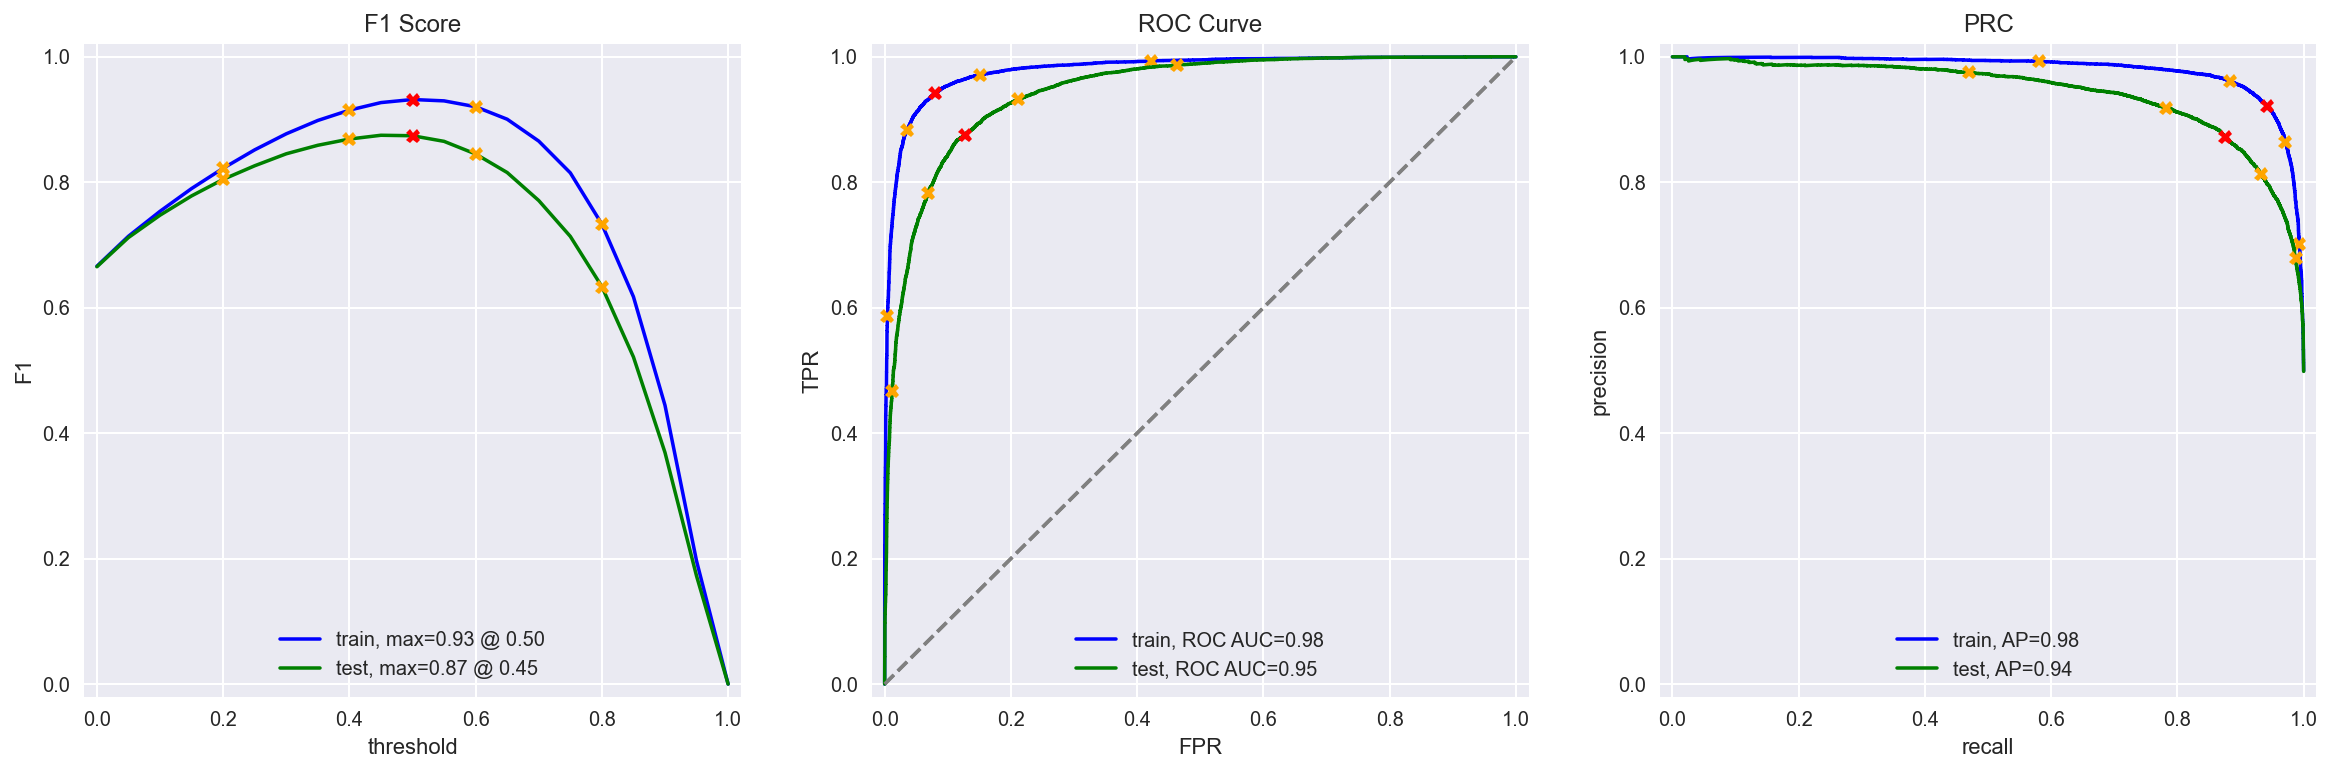

In [35]:
%%time
model_3 = LogisticRegression(random_state=12345,solver='liblinear')
model_3.fit(train_features_3,train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

* It is the same with NLP , lemmatization took long time 
* results are the same for both of the models using NLTK AND NLP, except of the APS value on the testset for the model using NLTK 

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

          train  test
Accuracy    1.0  0.86
F1          1.0  0.86
APS         1.0  0.93
ROC AUC     1.0  0.94
CPU times: total: 4min 4s
Wall time: 1min 32s


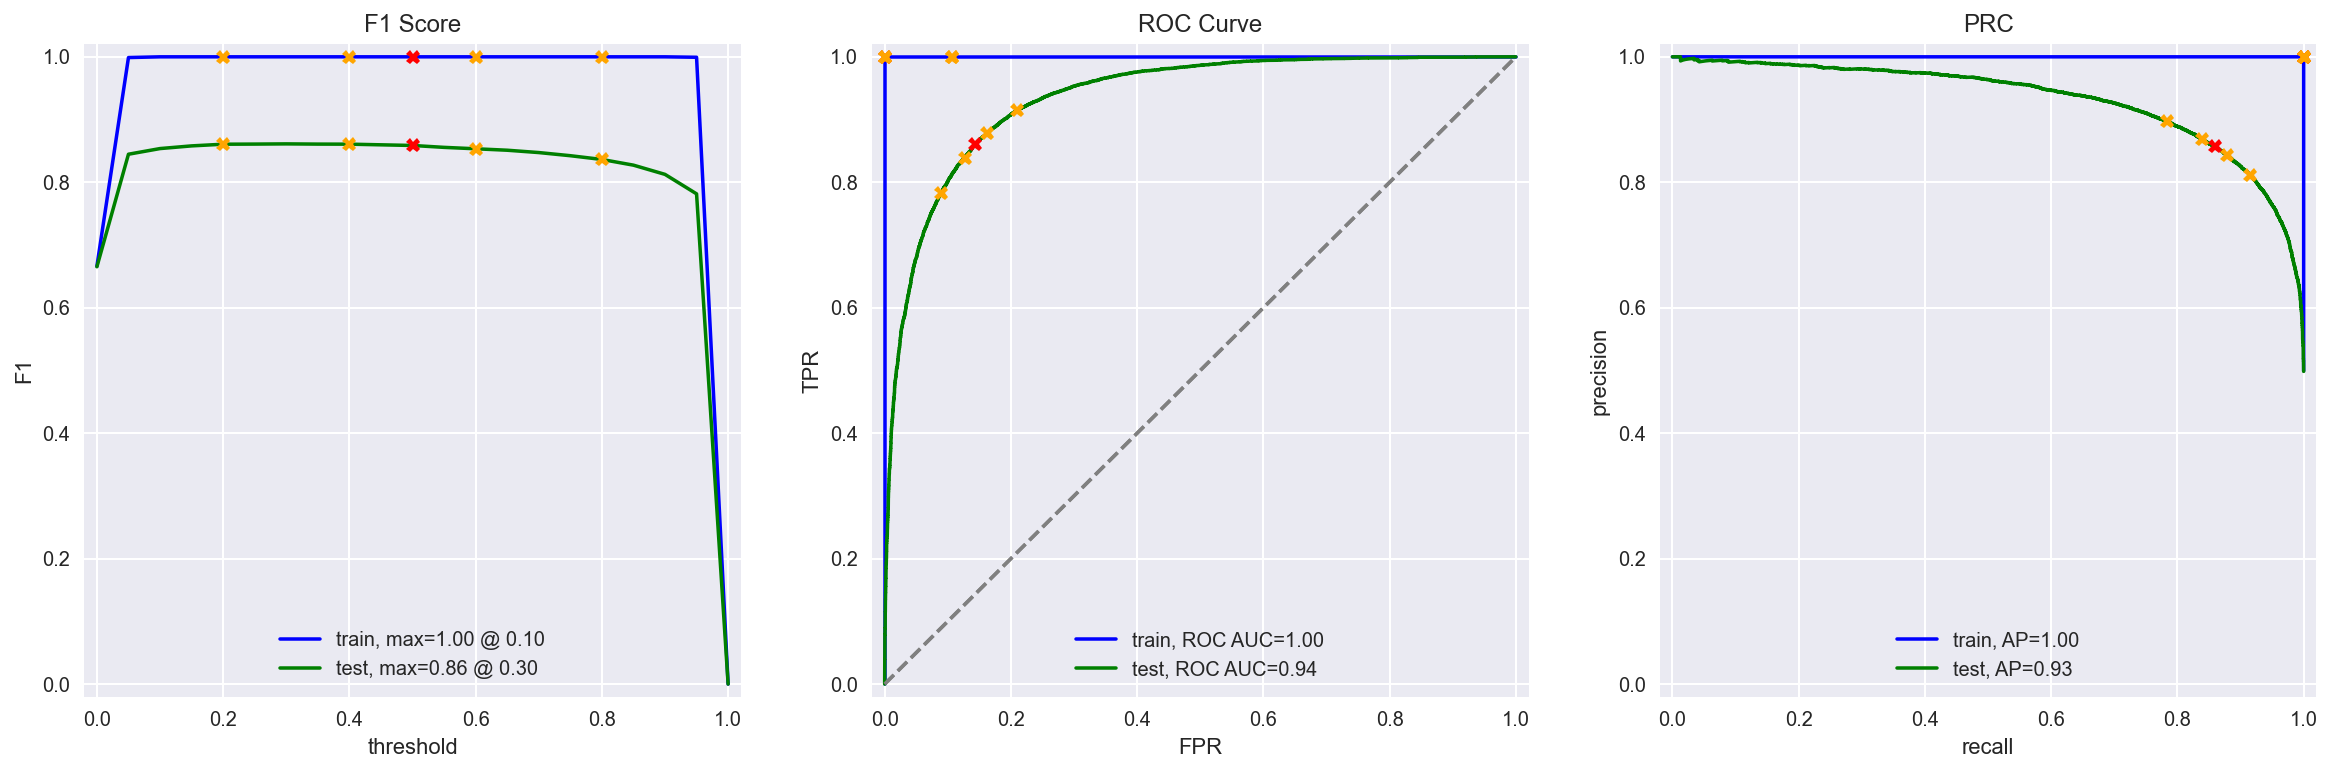

In [37]:
%%time
model_4 = LGBMClassifier(random_seed=12345,n_estimators=300,learning_rate = 0.5)
model_4.fit(train_features_3, train_target)
evaluate_model(model_4,train_features_3, train_target, test_features_3, test_target)

* Fitting and evaluating model took long time 
* metric results are 1.0 for the train set, on the other hand for the test set we get lower values
* The logisitc regression with TF-IDF result in higher values for the accuracy and F1 score 

### Model 5 - spaCy, TF-IDF and CatBoostClassifier

In [38]:
 import catboost as ctb

          train  test
Accuracy   0.98  0.85
F1         0.98  0.85
APS        1.00  0.92
ROC AUC    1.00  0.93
CPU times: total: 26min 40s
Wall time: 10min 14s


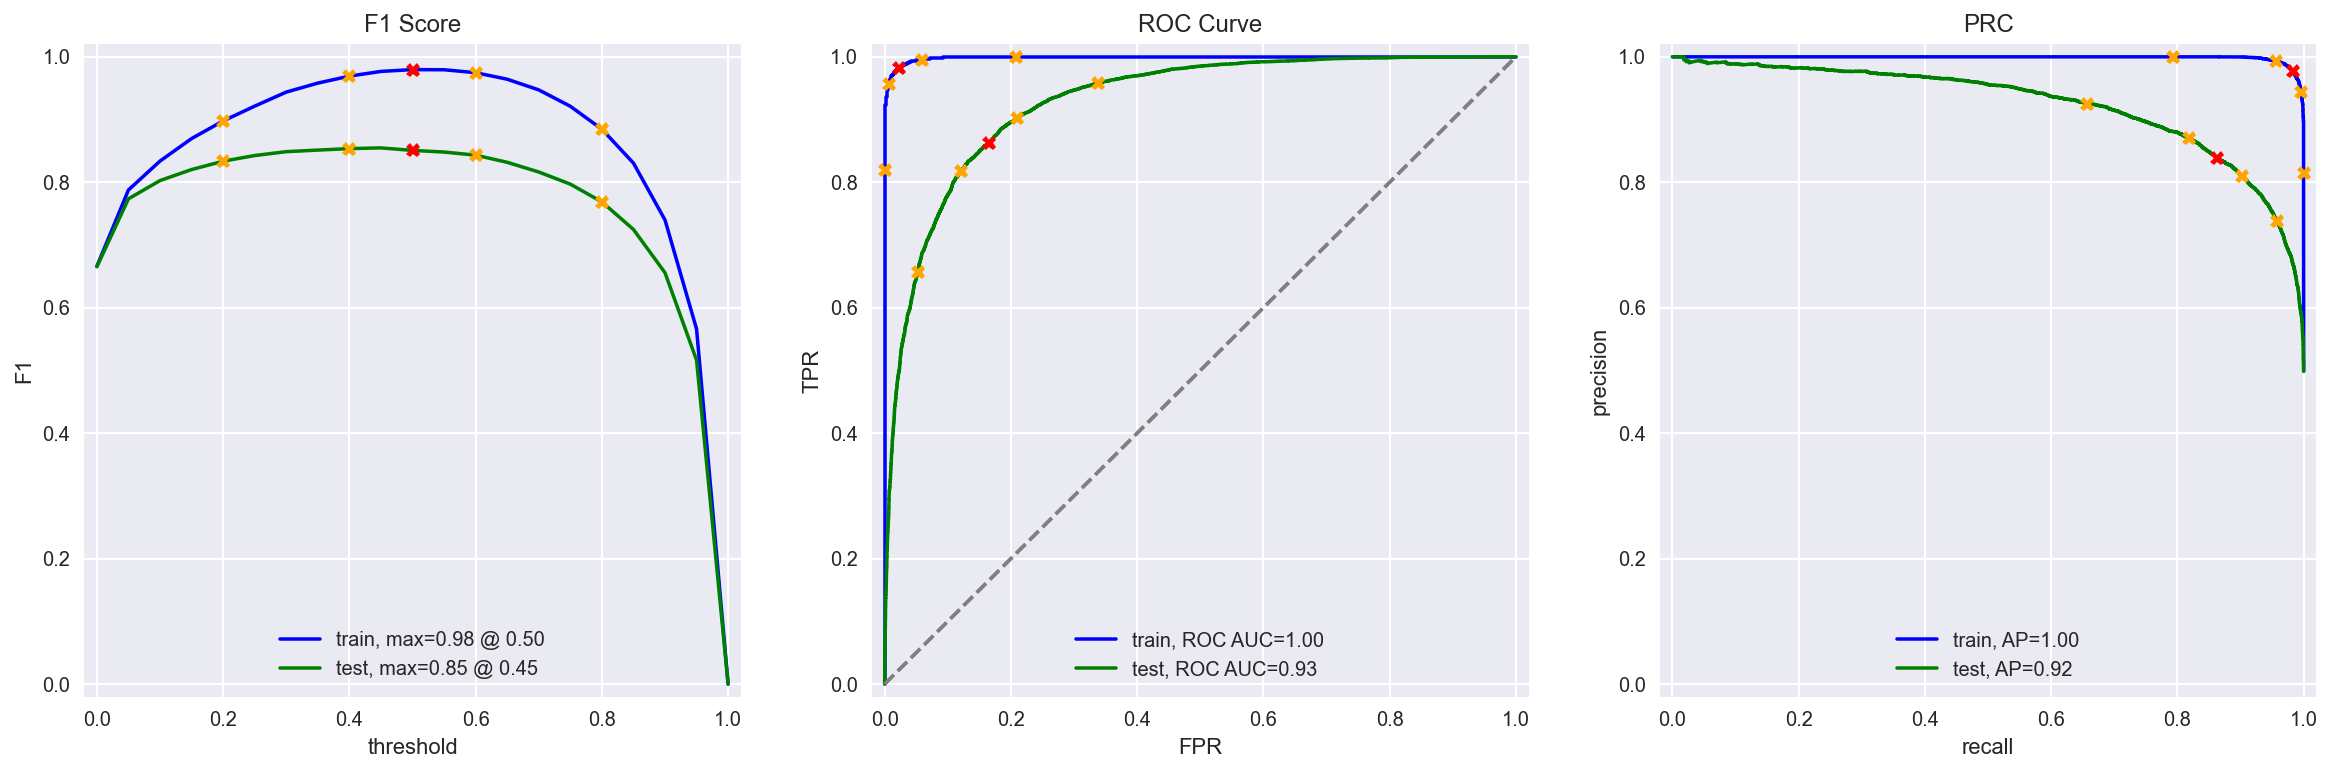

In [45]:
%%time
model_5 = ctb.CatBoostClassifier(loss_function="Logloss",silent=True, iterations=300,learning_rate = 0.5)
model_5.fit(train_features_3, train_target)
evaluate_model(model_5,train_features_3, train_target, test_features_3, test_target)

* The gradient boosting models got the same behaviour, for this model it took less time 
  * Fitting and evaluating model took long time 
  * metric results are 1.0 for the train set, on the other hand for the test set we get lower values
  * The logisitc regression with TF-IDF result in higher values for the accuracy and F1 score 

## My Reviews

In [46]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(clear_text_gen,axis=1)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [47]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didn t expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.06:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [48]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didn t expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [49]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.03:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.06:  i didn t expect the reboot to be so good writers really cared about the source material
0.91:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.01:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.99:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [50]:
texts = my_reviews['review_norm']

tfidf_vectorizer_5 = tfidf_vectorizer_3
my_reviews_pred_prob = model_5.predict_proba(tfidf_vectorizer_5.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.30:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.66:  i didn t expect the reboot to be so good writers really cared about the source material
0.56:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


* seventh reiew got low probabilty all over the models 
* the last review got the highest probability among all the reviews on each model 
* lightGBM perform the best among the models, got more accurate probabilities

## Conclusions

* On the first stage, we observe the data:
  * a dataframe of 47331 entries, with 17 attributes
  * Null values exist in 2 ccolumns only (small proportion - 2 entries only)
* On the EDA stage, we observe distribution of the data found: 
  * number of review vs the number of movies per year, the graphs look the same the distribution look similar on both of the graphs
  * Distribution of the ratings for both of the sets look very similar
  * Distribution of the reviews for both of the sets look very similar, test set got more reviews
* Model Evaluation:
  * fot the dummy model All of the other metrics is equal to 0.5, except of F1 score
  * Logistic Regression with TF-IDF using NLTK and NLP got us similar metric results 
  * also Gradient Boosting models got us similar metric results, the lightGBM took more time 
* Observing the probabilities on the last stage: 
   * lightGBM perform the best among the models, got more accurate probabilities